In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None                              # to get away from the huge warning list on the copy

In [81]:
import chardet
with open('../data/Exported_Parameter_Data/Gyro_XYZ_WIMU_11_06th_March_2018.csv', 'rb') as f:
    result = chardet.detect(f.readline())  # or readline if the file is large
result
df=pd.read_csv('../data/Exported_Parameter_Data/Gyro_XYZ_WIMU_11_06th_March_2018.csv',sep='\t',encoding='utf-16')
df=df.rename(columns=lambda x: x.strip())  #Remove trailing whitespaces
df.TIME = pd.to_datetime(df.TIME, format='%H:%M:%S %f')
df.TIME = df.TIME.astype('int64')//-1000000
df['WIMU_11  GYRO X(degs/s)'] = df['WIMU_11  GYRO X(degs/s)'].str.replace(',','.').astype('float64')
df['WIMU_11  GYRO Y(degs/s)'] = df['WIMU_11  GYRO Y(degs/s)'].str.replace(',','.').astype('float64')
df['WIMU_11  GYRO Z(degs/s)'] = df['WIMU_11  GYRO Z(degs/s)'].str.replace(',','.').astype('float64')
df.rename(columns={'TIME':'time','WIMU_11  GYRO X(degs/s)':'gyro_x','WIMU_11  GYRO Y(degs/s)':'gyro_y','WIMU_11  GYRO Z(degs/s)':'gyro_z'},inplace=True)

In [86]:
df.head()

,time,gyro_x,gyro_y,gyro_z,SELECT,BANDS
0,2208942238641,0.026747,-0.394802,0.528371,NaN,NaN
1,2208942238631,-0.018961,-0.496490,0.482662,NaN,NaN
2,2208942238621,0.026809,-0.587969,0.467364,NaN,NaN
3,2208942238611,0.092843,-0.598147,0.513135,NaN,NaN
4,2208942238601,-0.034197,-0.770958,0.518193,NaN,NaN


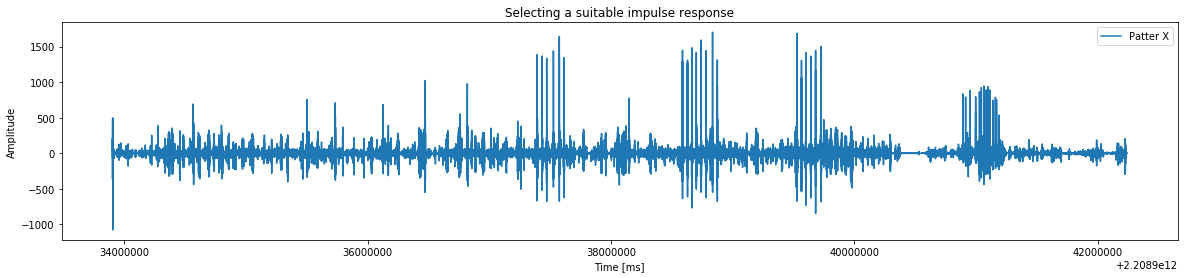

In [90]:
dfS = df
fig = plt.figure(figsize=[20,4])
plt.ylabel("Amplitude")
plt.xlabel("Time [ms]")
plt.plot(dfS['time'], dfS['gyro_x'],label="Patter X")

plt.legend()
plt.title('Inspect wave')
plt.show()

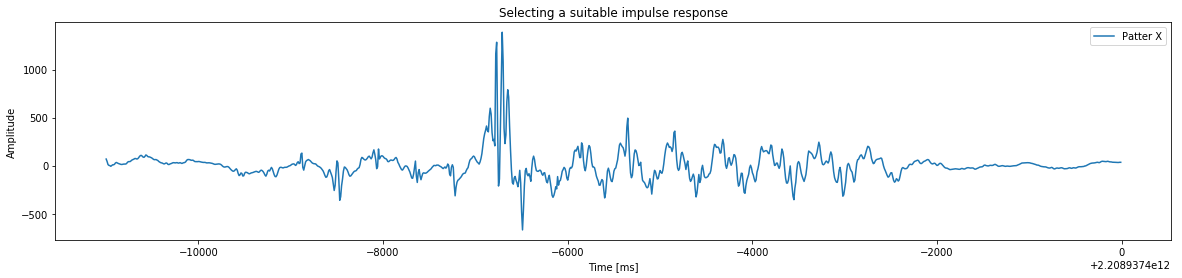

In [99]:
# Selecting pulse
start=2.208937e12
dfP = df.loc[(df['time']>start+389000) & (df['time']<start+400000)]
fig = plt.figure(figsize=[20,4])
plt.ylabel("Amplitude")
plt.xlabel("Time [ms]")
plt.plot(dfP['time'], dfP['gyro_x'],label="Patter X")

plt.legend()
plt.title('Selecting a suitable impulse response')
plt.show()

In [100]:
dfP

,time,gyro_x,gyro_y,gyro_z,SELECT,BANDS
483865,2208937399991,34.449760,-9.921861,15.968203,NaN,NaN
483866,2208937399981,34.780365,-10.704831,15.205682,NaN,NaN
483867,2208937399971,33.031403,-12.453698,13.827911,NaN,NaN
483868,2208937399961,32.619560,-13.999283,11.941826,NaN,NaN
483869,2208937399951,33.565228,-15.066774,9.171082,NaN,NaN
...,...,...,...,...,...,...
484960,2208937389041,-0.204153,-59.845650,1.931244,NaN,NaN
484961,2208937389031,2.488269,-72.073135,1.179770,NaN,NaN
484962,2208937389021,10.632469,-83.430023,2.667544,NaN,NaN
484963,2208937389011,42.662323,-74.159775,8.270380,NaN,NaN


In [120]:
def findPatterns(dfS,dfP,threshold,axis_name,time_name):
    from scipy import signal
    from scipy.signal import argrelextrema

    n=len(dfP)
    pd.options.mode.chained_assignment = None                              # to get away from the huge warning list on the copy
    filtered_col = 'filtered_'+axis_name
    filtered_max_col = 'filtered_'+axis_name+'_max'
    filtered_thres_col= 'filtered_'+axis_name+'_threshold'
    start_pulse_col = 'start_pulse_'+axis_name
    end_pulse_col = 'end_pulse_'+axis_name
    # df['min'] = df.iloc[argrelextrema(df.data.values, np.less_equal, order=n)[0]]['data']
    dfS[filtered_col]=signal.convolve(dfS[axis_name], dfP[axis_name], mode='same') / (sum(dfP[axis_name]))
    dfS[filtered_max_col] = dfS.iloc[argrelextrema(dfS[filtered_col].values, np.greater_equal, order=n)[0]][filtered_col]
    dfS[filtered_thres_col]=dfS[filtered_max_col].copy(deep=True)
    dfS[filtered_thres_col].loc[dfS[filtered_thres_col]<threshold] =np.NaN

    pulse_width=np.abs(dfP.iloc[-1][time_name]-dfP.iloc[0][time_name])

    middlePoints=dfS[dfS[filtered_thres_col].notnull()]
    dfS[start_pulse_col]=np.NaN
    dfS[end_pulse_col]=np.NaN
    pulse_count = 1
    for index,row in middlePoints.iterrows():
        start_time = int(np.abs(row[time_name] - pulse_width//2))
        end_time = row[time_name] + pulse_width//2
        dfS.at[dfS.loc[(dfS[time_name]>start_time) & (dfS[time_name]<start_time+10)].index,start_pulse_col] = pulse_count
        dfS.at[dfS.loc[(dfS[time_name]>end_time)&(dfS[time_name]<end_time+10)].index,end_pulse_col] = pulse_count
        pulse_count+=1

    fig = plt.figure(figsize=[20,4])
    plt.ylabel("Amplitude")
    plt.xlabel("Time [ms]")
    plt.plot(dfS[time_name], dfS[axis_name],label="signal "+axis_name)
    # plt.plot(dfS['time'], dfS['filtered_orig'],label="Filtered")
    for index,row in dfS[dfS[start_pulse_col].notnull()].iterrows():
        plt.axvline(x=row[time_name],color='k')
    for index,row in dfS[dfS[end_pulse_col].notnull()].iterrows():
        plt.axvline(x=row[time_name],color='k')

    plt.scatter(dfS[time_name], dfS[filtered_thres_col],label="Middle Pulse", color='r')
    plt.plot(dfS[time_name], dfS[filtered_col],label="Convolved signal "+axis_name)
    plt.legend()
    plt.show()
    
    return dfS

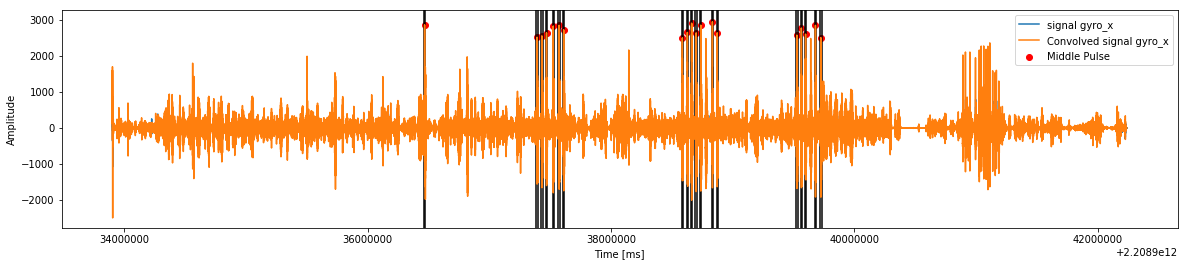

In [121]:
reusult = findPatterns(dfS,dfP,2500,'gyro_x','time')

NameError: name 'axis_name' is not defined

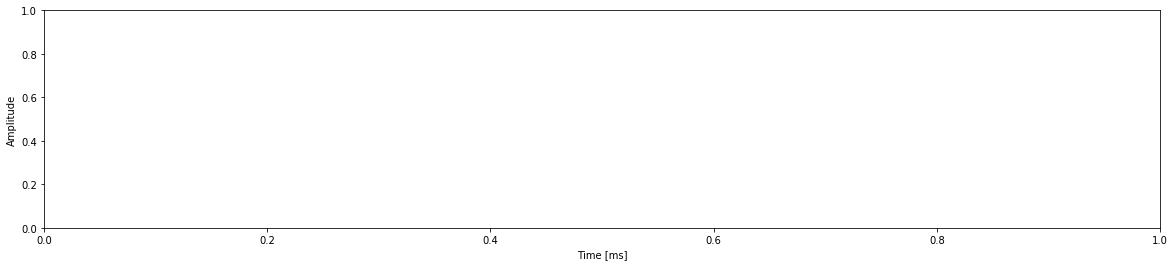

In [122]:
dfS = df
fig = plt.figure(figsize=[20,4])
plt.ylabel("Amplitude")
plt.xlabel("Time [ms]")
plt.plot(dfS['time'], dfS['filtered_gyro_x']/sum(dfP['axis_name']),label="Patter X")

plt.legend()
plt.title('Inspect wave')
plt.show()